<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/SDS_RegionSurvey_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3조. 건강검진 데이터를 활용한 치아우식증 발생 예측

## - Version 7. 지역사회조사 외부 데이터 Handling

## 1. 작업 환경 세팅

### 1-1. 구글 드라이브 인증

In [3]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# 학교 g guite 사용 시: 학교 g suite 구글 드라이브에 연결해 놓았으니, 성대 킹고 로그인해서 구글 드라이브 켜놓고 아래 결과창에 나오는 url 클릭해서 성대 gmail로 로그인하면 됨
# 데이터 경로는 본인 drive 내의 /sds/data 경로로 fix

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
Mounted at /gdrive


In [4]:
!ls /gdrive/My\ Drive/sds/data

 완료_구강검진결과_14년도_교육이후개별비.csv
 완료_구강검진결과_14년도_총수검인원기준비.csv
 chs11_all.txt
 chs12_all.txt
 chs_12c.csv
 chs_12_eng.csv
 chs_12_final_from_python.csv
 chs_12_iv.csv
 chs_12_iv_second.csv
 chs_12_rf_importances_2nd.csv
 chs_12_rf_importances.csv
 chs_12_var_selected.csv
 chs_12_var_selected_final.csv
 chs_12_var_selected_final.xlsx
 chs_12_var_selected_original.csv
 chs_12_변수선택.xlsx
 chs13_all.txt
 chs14_all.txt
 chs15_all.txt
 chs16_all.txt
 chs17_all.xls
'chs 2012 상관관계.xlsx'
 cummunity_survey_corr.csv
 DentalExamineResult_2014_PortionbyTotInspector.csv
'데이터 레이아웃 및 한글 영문 매칭_최종.gsheet'
'완료_KOSIS 연령별 성별 치과 평균 수진횟수 2012.csv'
'완료_KOSIS 치주질환 유병률 추이_2012.csv'
 KOSIS_AgeSex_AverageDentalVisitCnt_2012.csv
 KOSIS_DentalPrevalenceTrend_2012.csv
 nanum
 NHIS_OPEN_GJ_2010.csv
 NHIS_OPEN_GJ_2011.csv
 NHIS_OPEN_GJ_2011_eng.csv
 NHIS_OPEN_GJ_2012.csv
 NHIS_OPEN_GJ_2012_eng.

### 1-2. 라이브러리 로딩

In [5]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

# Deep Learning Model 로드
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.wrappers.scikit_learn import KerasClassifier

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

Using TensorFlow backend.


### AUC Graph 그리는 함수 선언

In [0]:
def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

## 2. 파일 Read 및 기초 탐색

In [0]:
# set_random_seed = 77 # 62.9
set_random_seed = 777 # 62.7
set_cv = 2

In [8]:
#### 2012년 기준 #########################################################################################################################################
# 참고 - 데이터 concat시 index 문제로 병합이 안되면 아래 코드 수행 후 다시 concat
df_survey_2012 = pd.read_csv('../gdrive/My Drive/sds/data/chs_12_eng.csv', encoding = 'euc-kr')

# 컬럼명 내 불필요한 공백 및 특수문자 제거
df_survey_2012.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)
df_raw = df_survey_2012[df_survey_2012['target']!=2]
display(df_raw.sample(5))

,josa_year,id,age,sex,city_cd,bogun_cd,jijum_cd,gagu_cd,gaguw_cd,town_t,apt_t,h_admincode,kstrata,wt_house,wt,fma_01z1,fma_02z1,fma_19z1,fma_04z1,fma_10z1,fma_12z1,fma_20z1,fma_18z1,sma_01z2,sma_02z1,sma_03z2,smb_01z1,smb_02z1,smb_03z1,smb_04z1,smb_05z1,smb_06z1,smd_02z2,smd_05a2,smd_05b2,smd_05c2,smd_05d2,smd_01z2,smd_03z2,smd_06z1,...,qoc_05z1,qoc_06z1,hma_01z1,hma_02z3,hma_04a1,hma_04b1,hma_04c1,hma_04d1,hma_04e1,hma_04f1,hma_04g1,hma_04h1,hma_04i1,hma_04j1,hma_04k1,hma_05z1,hmb_01z2,hmc_01a1,hmc_01b1,hmc_01c1,hmc_01d1,hmc_01e1,cpr_01z1,cpr_02z1,cpr_03z1,cpr_04z1,soa_01z1,soa_06z1,soa_07z1,sob_01z1,sob_02z1,soc_02z1,sod_01z1,sod_02z1,soe_01z1,soe_02z1,chs_sex,chs_ageband,chs_province,target
174858,2012,2012M19402501000502,47,2,M,194,2501,5,2,2,1,46870,4349,41.67937,41.74711,3,3,29,2,1,2,20,2,2,888,8,888,88,888,88,88,888,8,8,8,8,8,8,88,1,...,2,60,2,2,1,2,2,2,2,2,2,2,1,2,2,2,88,2,2,2,2,2,2,8,8,8,2,13,8,3,1,1,1,4,3,3,Female,45,Jeonnam,1
171980,2012,2012M19106172002201,64,1,M,191,6172,22,1,1,2,46150,4263,236.40781,411.22692,2,2,11,3,2,2,300,2,1,17,3,888,88,888,15,0,12,8,8,8,8,8,8,3,1,...,1,70,1,88,8,8,8,8,8,8,8,8,8,8,8,8,7,2,2,2,2,2,1,3,8,2,1,3,2,5,1,1,1,1,5,5,Male,60,Jeonnam,1
65395,2012,2012G07206072002601,38,1,G,72,6072,26,1,1,2,31200,2004,138.87031,157.10862,4,2,21,3,2,1,7000,2,1,20,1,15,88,888,88,88,888,2,1,2,2,2,4,2,1,...,1,70,1,88,8,8,8,8,8,8,8,8,8,8,8,8,8,2,2,2,2,2,1,2,8,3,1,7,2,5,1,1,1,1,2,2,Male,35,Ulsan,0
192826,2012,2012N21408481001201,60,2,N,214,8481,12,1,1,1,47170,4691,133.72196,129.90205,2,2,11,3,1,2,50,2,2,888,8,888,88,888,88,88,888,8,8,8,8,8,8,88,1,...,1,70,2,7,2,2,1,2,2,2,2,2,2,2,2,2,88,2,2,2,2,2,1,3,8,2,2,12,8,3,1,1,1,1,5,5,Female,60,Gyungbuk,1
18045,2012,2012A02031621000401,71,2,A,20,31621,4,1,1,1,11560,607,376.27494,329.37080,1,1,10,3,1,1,500,2,2,888,8,888,88,888,88,88,888,8,8,8,8,8,8,88,1,...,1,50,1,88,8,8,8,8,8,8,8,8,8,8,8,8,1,2,2,2,2,2,2,8,8,8,2,12,8,3,1,1,1,3,5,5,Female,70,Seoul,1


### 2-1. 컬럼명 정제 및 기초 탐색

In [9]:
# 타겟 변수 지정
target_nm = 'target'
print(df_raw[target_nm].value_counts())

0    136123
1     92778
Name: target, dtype: int64


In [0]:
df_data = df_raw[~(df_raw[target_nm].isnull()) & (df_raw[target_nm] != 2)]

## 3. Simple EDA
1. 데이터 임포트 후 메모리에 upload 
2. 데이터의 모양 확인
3. 데이터의 타입 확인
4. 데이터의 Null 값을 체크
5. 종속변수의 분포 체크
6. 독립변수 - 명목형 변수의 분포 체크
7. 독립변수 - 수치형 변수의 분포 체크
8. 수치형, 명목형 변수간의 관계 파악

### 3-1. 데이터의 모양 및 타입 확인

In [11]:
# EDA 진행 할 데이터 모양 확인 및 데이터 타입 확인
display(df_data.sample(5))
display(df_data.dtypes)

,josa_year,id,age,sex,city_cd,bogun_cd,jijum_cd,gagu_cd,gaguw_cd,town_t,apt_t,h_admincode,kstrata,wt_house,wt,fma_01z1,fma_02z1,fma_19z1,fma_04z1,fma_10z1,fma_12z1,fma_20z1,fma_18z1,sma_01z2,sma_02z1,sma_03z2,smb_01z1,smb_02z1,smb_03z1,smb_04z1,smb_05z1,smb_06z1,smd_02z2,smd_05a2,smd_05b2,smd_05c2,smd_05d2,smd_01z2,smd_03z2,smd_06z1,...,qoc_05z1,qoc_06z1,hma_01z1,hma_02z3,hma_04a1,hma_04b1,hma_04c1,hma_04d1,hma_04e1,hma_04f1,hma_04g1,hma_04h1,hma_04i1,hma_04j1,hma_04k1,hma_05z1,hmb_01z2,hmc_01a1,hmc_01b1,hmc_01c1,hmc_01d1,hmc_01e1,cpr_01z1,cpr_02z1,cpr_03z1,cpr_04z1,soa_01z1,soa_06z1,soa_07z1,sob_01z1,sob_02z1,soc_02z1,sod_01z1,sod_02z1,soe_01z1,soe_02z1,chs_sex,chs_ageband,chs_province,target
67375,2012,2012G07405051000201,30,1,G,74,5051,2,1,1,1,31110,2047,194.36825,247.00825,2,2,11,3,1,2,200,2,1,18,3,888,88,888,8,0,20,8,8,8,8,8,8,2,1,...,1,90,1,88,8,8,8,8,8,8,8,8,8,8,8,8,3,2,2,2,2,2,1,2,8,2,1,7,1,6,1,1,1,1,1,1,Male,30,Ulsan,1
17318,2012,2012A01932092001101,62,2,A,19,32092,11,1,1,2,11470,585,336.92308,327.41630,5,4,31,3,2,9,99999,2,2,888,8,888,88,888,88,88,888,8,8,8,8,8,8,88,1,...,1,80,1,88,8,8,8,8,8,8,8,8,8,8,8,8,9,2,2,2,2,2,1,3,8,3,2,12,8,3,1,1,1,1,5,2,Female,60,Seoul,0
86858,2012,2012H09504412000103,40,1,H,95,4412,1,3,1,2,41450,2448,117.24889,121.31626,4,4,21,3,2,1,8200,2,1,17,3,888,88,888,10,1,1,8,8,8,8,8,8,2,1,...,1,80,1,88,8,8,8,8,8,8,8,8,8,8,8,8,8,1,1,2,2,2,1,2,8,2,1,2,1,6,1,1,1,1,1,1,Male,40,Gyeonggi,0
125419,2012,2012J13802801000802,85,2,J,138,2801,8,2,2,1,43760,3259,30.02703,29.96164,3,3,25,3,1,2,100,2,2,888,8,888,88,888,88,88,888,8,8,8,8,8,8,88,1,...,1,40,4,1,1,2,2,2,2,2,2,2,1,2,2,2,88,2,2,2,2,2,2,8,8,8,2,13,8,1,8,2,1,3,5,5,Female,85,Chungbuk,1
24616,2012,2012B02700721001002,59,2,B,27,721,10,2,1,1,26410,793,208.47187,172.15762,2,2,11,3,1,2,150,2,2,888,8,888,88,888,88,88,888,8,8,8,8,8,8,88,2,...,1,50,1,88,8,8,8,8,8,8,8,8,8,8,8,8,7,2,2,2,2,2,1,3,8,3,1,9,1,3,1,1,1,1,5,5,Female,55,Busan,1


josa_year        int64
id              object
age              int64
sex              int64
city_cd         object
                 ...  
soe_02z1         int64
chs_sex         object
chs_ageband      int64
chs_province    object
target           int64
Length: 290, dtype: object

In [12]:
for col in df_data.columns:
  if df_data[col].dtype == 'object':
    print(col)

id
city_cd
chs_sex
chs_province


In [0]:
df_data.drop(['id','city_cd'], axis=1, inplace=True)

### 3-2. 데이터 NULL 값 체크

In [14]:
# Null Value Check
print('# Null Value Check in Data \n ---------------------------------------------------- ')
print(df_data.isnull().sum())

# Null Value Check in Data 
 ---------------------------------------------------- 
josa_year       0
age             0
sex             0
bogun_cd        0
jijum_cd        0
               ..
soe_02z1        0
chs_sex         0
chs_ageband     0
chs_province    0
target          0
Length: 288, dtype: int64


#### 3-2-1. 데이터 NULL 값의 비중이 크지 않으므로 일단 null 값을 모두 삭졔

In [15]:
# null 포함 데이터 모두 삭제 
df_data.dropna(how='any', inplace=True)
display(df_data.info())
print(len(df_data))

print(df_data[target_nm].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228901 entries, 0 to 228920
Columns: 288 entries, josa_year to target
dtypes: float64(4), int64(282), object(2)
memory usage: 504.7+ MB


None

228901
0    136123
1     92778
Name: target, dtype: int64


In [16]:
df_data.dtypes

josa_year        int64
age              int64
sex              int64
bogun_cd         int64
jijum_cd         int64
                 ...  
soe_02z1         int64
chs_sex         object
chs_ageband      int64
chs_province    object
target           int64
Length: 288, dtype: object

In [17]:
df_data_wrangling = pd.DataFrame()

for i in tqdm_notebook(df_data.columns):
    col_max = df_data[i].max()
    # print(df_data[i].values)
    if (col_max == 7) | (col_max == 8) | (col_max == 9):
      df_data_wrangling[i] =  df_data[i].apply(lambda x: 0 if x >=7 else x)
    elif (col_max == 77) | (col_max == 88) | (col_max == 99):
      df_data_wrangling[i] =  df_data[i].apply(lambda x: 0 if x >=77 else x)
    elif (col_max == 777) | (col_max == 888) | (col_max == 999):
      df_data_wrangling[i] =  df_data[i].apply(lambda x: 0 if x >=777 else x)
    else:
      df_data_wrangling[i] = df_data[i]

In [18]:
# 1. 0과 1을 50% 비율로 추출하여 원본데이터 비율대로 추출
df_sample = df_data_wrangling.groupby(target_nm).apply(lambda x: x.sample(frac=1)).copy()
df_sample.reset_index(drop=True, inplace=True)

print(df_sample[target_nm].value_counts())
print(df_sample[target_nm].value_counts()/len(df_sample[target_nm]))

0    136123
1     92778
Name: target, dtype: int64
0    0.594681
1    0.405319
Name: target, dtype: float64


In [19]:
df_sample.head()

,josa_year,age,sex,bogun_cd,jijum_cd,gagu_cd,gaguw_cd,town_t,apt_t,h_admincode,kstrata,wt_house,wt,fma_01z1,fma_02z1,fma_19z1,fma_04z1,fma_10z1,fma_12z1,fma_20z1,fma_18z1,sma_01z2,sma_02z1,sma_03z2,smb_01z1,smb_02z1,smb_03z1,smb_04z1,smb_05z1,smb_06z1,smd_02z2,smd_05a2,smd_05b2,smd_05c2,smd_05d2,smd_01z2,smd_03z2,smd_06z1,smd_07z1,dra_01z1,...,qoc_05z1,qoc_06z1,hma_01z1,hma_02z3,hma_04a1,hma_04b1,hma_04c1,hma_04d1,hma_04e1,hma_04f1,hma_04g1,hma_04h1,hma_04i1,hma_04j1,hma_04k1,hma_05z1,hmb_01z2,hmc_01a1,hmc_01b1,hmc_01c1,hmc_01d1,hmc_01e1,cpr_01z1,cpr_02z1,cpr_03z1,cpr_04z1,soa_01z1,soa_06z1,soa_07z1,sob_01z1,sob_02z1,soc_02z1,sod_01z1,sod_02z1,soe_01z1,soe_02z1,chs_sex,chs_ageband,chs_province,target
0,2012,48,2,80,6711,46,1,1,1,41310,2142,156.66667,124.09907,3,3,23,3,4,2,250,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,...,1,80,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9,1,2,2,2,2,2,0,0,0,1,0,0,5,1,2,1,3,5,5,Female,45,Gyeonggi,0
1,2012,71,2,135,1341,16,2,2,1,42720,3232,51.91632,73.57371,4,3,32,3,1,2,400,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,...,1,90,2,2,1,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,0,0,0,2,13,0,4,1,1,1,3,5,5,Female,70,Gangwon,0
2,2012,45,1,113,17811,75,1,1,1,41463,2829,172.34985,168.54305,5,2,21,3,4,2,400,2,1,18,3,0,0,0,19,0,10,0,0,0,0,0,0,1,2,2,1,...,1,98,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2,2,2,2,2,2,0,0,0,1,7,2,4,1,1,1,1,2,2,Male,45,Gyeonggi,0
3,2012,28,2,105,1521,12,1,1,1,41115,2651,186.58333,180.15170,1,1,10,3,1,0,77777,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,...,1,70,2,7,2,2,2,2,2,2,2,2,2,1,2,3,0,2,2,2,2,2,1,3,0,3,2,11,0,7,4,2,2,0,5,5,Female,25,Gyeonggi,0
4,2012,36,1,102,14842,45,2,1,2,41113,2597,259.36076,374.35463,6,4,31,3,2,2,500,2,1,19,3,0,0,0,10,0,20,0,0,0,0,0,0,3,1,2,1,...,1,70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,2,2,2,2,1,2,0,3,1,3,2,7,1,1,1,1,5,5,Male,35,Gyeonggi,0


### 3-3. 데이터 Unique 값 체크

In [20]:
print('## Unique Value Check')
print("-"*25)
print('# Col Name: Unique Value / Total Size')
print("-"*25)

for col in df_sample.columns:
    print(col, ':', df_sample[col].unique().size, '/', len(df_sample[col]))  

## Unique Value Check
-------------------------
# Col Name: Unique Value / Total Size
-------------------------
josa_year : 1 / 228901
age : 86 / 228901
sex : 2 / 228901
bogun_cd : 253 / 228901
jijum_cd : 5545 / 228901
gagu_cd : 967 / 228901
gaguw_cd : 12 / 228901
town_t : 2 / 228901
apt_t : 2 / 228901
h_admincode : 251 / 228901
kstrata : 5451 / 228901
wt_house : 5336 / 228901
wt : 67825 / 228901
fma_01z1 : 12 / 228901
fma_02z1 : 7 / 228901
fma_19z1 : 20 / 228901
fma_04z1 : 4 / 228901
fma_10z1 : 7 / 228901
fma_12z1 : 3 / 228901
fma_20z1 : 416 / 228901
fma_18z1 : 3 / 228901
sma_01z2 : 3 / 228901
sma_02z1 : 78 / 228901
sma_03z2 : 4 / 228901
smb_01z1 : 46 / 228901
smb_02z1 : 32 / 228901
smb_03z1 : 24 / 228901
smb_04z1 : 73 / 228901
smb_05z1 : 12 / 228901
smb_06z1 : 48 / 228901
smd_02z2 : 4 / 228901
smd_05a2 : 3 / 228901
smd_05b2 : 3 / 228901
smd_05c2 : 3 / 228901
smd_05d2 : 3 / 228901
smd_01z2 : 5 / 228901
smd_03z2 : 10 / 228901
smd_06z1 : 3 / 228901
smd_07z1 : 3 / 228901
dra_01z1 : 3 / 2

In [21]:
df_sample['fma_12z1'].value_counts()

2    159420
1     56206
0     13275
Name: fma_12z1, dtype: int64

In [22]:
# 가족 수입을 모두 연수입으로 환산
df_sample = df_sample[df_sample['fma_12z1'] <= 2]
df_sample['Family_Income_per_Year'] = 0
for i in tqdm_notebook(range(len(df_sample))):
  df_sample['Family_Income_per_Year'].iloc[i] = df_sample['fma_20z1'].iloc[i] if df_sample['fma_12z1'].iloc[i] == 1 else df_sample['fma_20z1'].iloc[i] * 12

In [0]:
# 연수입 환산 후 이전 컬럼 drop
df_sample[['fma_12z1','fma_20z1','Family_Income_per_Year']]
df_sample.drop(columns=['fma_12z1','fma_20z1'], inplace=True)

In [0]:
# target 변수에 직접 영향을 미치는 변수 삭제
df_sample.drop(columns=['ora_01z1'], inplace=True)

## 4. 변수 선택 (Information Value 계산)

### 4-1. woe library 설치

In [25]:
# woe package install
! pip install woe

### 4-2. Library Load 및 환경 변수 세팅

In [0]:
# Calculate IV Setting
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string
import woe
from woe.eval import plot_ks

max_bin = 20
force_bin = 3

### 4-3. Information Value 산출 사용자 정의 함수 정의

In [0]:
# Define a binning function for continous independent variables
def mono_bin(Y, X, n = max_bin):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]
  r = 0
  while np.abs(r) < 1:
    try:
      global d1
      global d2
      d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
      d2 = d1.groupby('Bucket', as_index=True)
      r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
      n = n - 1 
    except Exception as e:
      n = n - 1
      break
      
  if len(d2) == 1:
    n = force_bin         
    bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
    if len(np.unique(bins)) == 2:
        bins = np.insert(bins, 0, 1)
        bins[1] = bins[1]-(bins[1]/2)
    d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
    d2 = d1.groupby('Bucket', as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["MIN_VALUE"] = d2.min().X
  d3["MAX_VALUE"] = d2.max().X
  d3["COUNT"] = d2.count().Y
  d3["EVENT"] = d2.sum().Y
  d3["NONEVENT"] = d2.count().Y - d2.sum().Y
  d3=d3.reset_index(drop=True)

  if len(justmiss.index) > 0:
      d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
      d4["MAX_VALUE"] = np.nan
      d4["COUNT"] = justmiss.count().Y
      d4["EVENT"] = justmiss.sum().Y
      d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
      d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()

  return(d3)
  
# Define a binning function for categorical independent variables
def char_bin(Y, X):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]    
  df2 = notmiss.groupby('X',as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["COUNT"] = df2.count().Y
  d3["MIN_VALUE"] = df2.sum().Y.index
  d3["MAX_VALUE"] = d3["MIN_VALUE"]
  d3["EVENT"] = df2.sum().Y
  d3["NONEVENT"] = df2.count().Y - df2.sum().Y

  if len(justmiss.index) > 0:
    d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
    d4["MAX_VALUE"] = np.nan
    d4["COUNT"] = justmiss.count().Y
    d4["EVENT"] = justmiss.sum().Y
    d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
    d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()
  d3 = d3.reset_index(drop=True)

  return(d3)

# Calculate Information Values
def calc_iv_all(df1, target):
    
  stack = traceback.extract_stack()
  filename, lineno, function_name, code = stack[-2]
  vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
  final = (re.findall(r"[\w']+", vars_name))[-1]

  x = df1.dtypes.index
  count = -1

  for i in tqdm_notebook(x):
    if i.upper() not in (final.upper()):
      if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
        conv = mono_bin(target, df1[i])
        conv["VAR_NAME"] = i
        count = count + 1
      else:
        conv = char_bin(target, df1[i])
        conv["VAR_NAME"] = i            
        count = count + 1

      if count == 0:
        iv_df = conv
      else:
        iv_df = iv_df.append(conv,ignore_index=True)

  iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
  iv = iv.reset_index()
  return(iv_df,iv)

### 4-4. IV 산출을 위한 data sampling 및 IV 산출

In [41]:
# IV 산출
first_iv_df, IV_first = calc_iv_all(df_sample,df_sample[target_nm])
# first_iv_df

,VAR_NAME,IV
1,age,0.535178
82,fma_01z1,0.110631
235,sfa_04z2,0.110631
192,phb_02z1,0.110631
191,phb_01z1,0.110631
190,pha_09z1,0.110631
189,pha_08z1,0.110631
232,sfa_01z1,0.110631
233,sfa_02z2,0.110631
234,sfa_03z1,0.110631


In [82]:
# IV 값 내림차순 정렬
IV_first_sorted = IV_first.sort_values('IV',ascending=False)
print(len(IV_first_sorted[IV_first_sorted['IV']>0.1]))
print(len(IV_first_sorted))

82
285


In [0]:
IV_first.to_csv('../gdrive/My Drive/sds/data/chs_12_iv.csv')

### 4-5. 최종 모델 입력 변수 선정

In [94]:
# 4. Information Value 기준 변수 선정(외부변수 추가) # test set accuracy 수준: 62.9%
need_cols = df_sample.columns

df_final = df_sample[need_cols].copy()
df_final.columns

Index(['josa_year', 'age', 'sex', 'bogun_cd', 'jijum_cd', 'gagu_cd',
       'gaguw_cd', 'town_t', 'apt_t', 'h_admincode',
       ...
       'soc_02z1', 'sod_01z1', 'sod_02z1', 'soe_01z1', 'soe_02z1', 'chs_sex',
       'chs_ageband', 'chs_province', 'target', 'Family_Income_per_Year'],
      dtype='object', length=286)

## 5. 모델 입력 전 최종 모델 입력에 맞게 입력 데이터 변형

In [0]:
data_x = df_final[df_final.columns.difference([target_nm])]
data_y = df_final[target_nm].astype('float64')

In [99]:
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

print("num_attribs: ", num_attribs)
print("cat_attribs: ", cat_attribs)

num_attribs:  ['obb_02c1', 'sod_01z1', 'hya_14c1', 'ara_18a1', 'sca_01z1', 'ara_18b1', 'caa_04z1', 'phc_01z1', 'pha_04z1', 'dia_10b1', 'scc_16b1', 'sfa_02z2', 'ama_10z1', 'qua_01z1', 'scb_04z1', 'osa_09c1', 'cva_10b1', 'hma_05z1', 'obs_04z1', 'dla_03c1', 'hya_13a1', 'drb_11z1', 'qoa_04z1', 'asa_01z1', 'ira_02z1', 'tha_09z1', 'hma_04k1', 'soc_02z1', 'nub_02z1', 'qoc_05z1', 'obb_02g1', 'sfb_07z1', 'hma_04d1', 'hya_06z1', 'pha_09z1', 'nud_01z1', 'dra_01z1', 'obs_02z1', 'scc_16e1', 'obs_05z1', 'dia_18z1', 'dia_21z1', 'dra_02z1', 'ana_04z1', 'gagu_cd', 'nuc_01z1', 'sra_02z1', 'hmc_01d1', 'asa_14z1', 'smb_02z1', 'mtc_01z1', 'phc_02z1', 'kstrata', 'dia_04z1', 'tha_10z1', 'smb_04z1', 'hya_13c1', 'pha_08z1', 'ara_20z1', 'fma_01z1', 'scc_15a1', 'scc_16d1', 'bogun_cd', 'soa_01z1', 'obb_02f1', 'qua_02z1', 'sfb_08z1', 'cva_10a1', 'sex', 'dia_14z1', 'ira_01z1', 'soa_07z1', 'smd_05d2', 'ama_09z1', 'hba_04z1', 'hma_04a1', 'osa_09b1', 'orc_01z1', 'drb_09z1', 'dia_17b1', 'cva_10d1', 'orb_01z1', 'pha_07z

In [0]:
label = LabelEncoder()
for col in data_x[cat_attribs].columns:   
  data_x[col] = label.fit_transform(data_x[col])
  data_x = pd.get_dummies(data_x, columns =[col], prefix=col+"_lb")

### 5-2. Train & Test 데이터 분리

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.3, random_state = set_random_seed)

In [102]:
display(train_x.shape)
display(test_x.shape)
display(train_y.shape)
display(test_y.shape)

(160230, 302)

(68671, 302)

(160230,)

(68671,)

In [0]:
def rf_run(train_x, train_y, test_x, test_y):
  model_rf = RandomForestClassifier(n_estimators=5, random_state=2).fit(train_x, train_y)
  pred_y_rf = model_rf.predict(test_x)
  pred_y_rf = (pred_y_rf>0.5)
  print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_rf)))
  print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_rf))
  print("Classification Report Matrix: \n", classification_report(test_y, pred_y_rf))
  return model_rf

In [0]:
# 특성 중요도 시각화 하기
def plot_feature_importances_rf(model, x):
    plt.figure(figsize=(20, 50))
    features = x.columns
    n_features = x.shape[1]
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel("attr importances", size=10)
    plt.ylabel("attr", size=10)
    plt.ylim(-1, n_features)
    plt.show()

In [0]:
def display_random_forest_feature_importances(model, x):
  feats = {} # a dict to hold feature_name: feature_importance
  for feature, importance in zip(x.columns, model.feature_importances_):
      feats[feature] = importance #add the name/value pair 

  importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
  importances_sorted = importances.sort_values(by='Gini-importance', ascending=False)
  display(importances_sorted)
  return importances_sorted

In [0]:
# IV 값 0.1 이상 컬럼 기준 모델 입력
iv_based_col = IV_first_sorted[IV_first_sorted['IV']>0.1]['VAR_NAME'].values.tolist()
train_x_iv1 = train_x[iv_based_col]
test_x_iv1 = test_x[iv_based_col]

In [109]:
# 전체 데이터 기준 모델 Run
rf_model_tot = rf_run(train_x, train_y, test_x, test_y)
# IV 값 0.1 이상 컬럼 기준 모델 Run
rf_model_iv1 = rf_run(train_x_iv1, train_y, test_x_iv1, test_y)

Accuracy: 0.74729
Confusion Matrix: 
 [[33028  7751]
 [ 9603 18289]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0       0.77      0.81      0.79     40779
         1.0       0.70      0.66      0.68     27892

    accuracy                           0.75     68671
   macro avg       0.74      0.73      0.74     68671
weighted avg       0.75      0.75      0.75     68671

Accuracy: 0.64110
Confusion Matrix: 
 [[30114 10665]
 [13981 13911]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0       0.68      0.74      0.71     40779
         1.0       0.57      0.50      0.53     27892

    accuracy                           0.64     68671
   macro avg       0.62      0.62      0.62     68671
weighted avg       0.64      0.64      0.64     68671



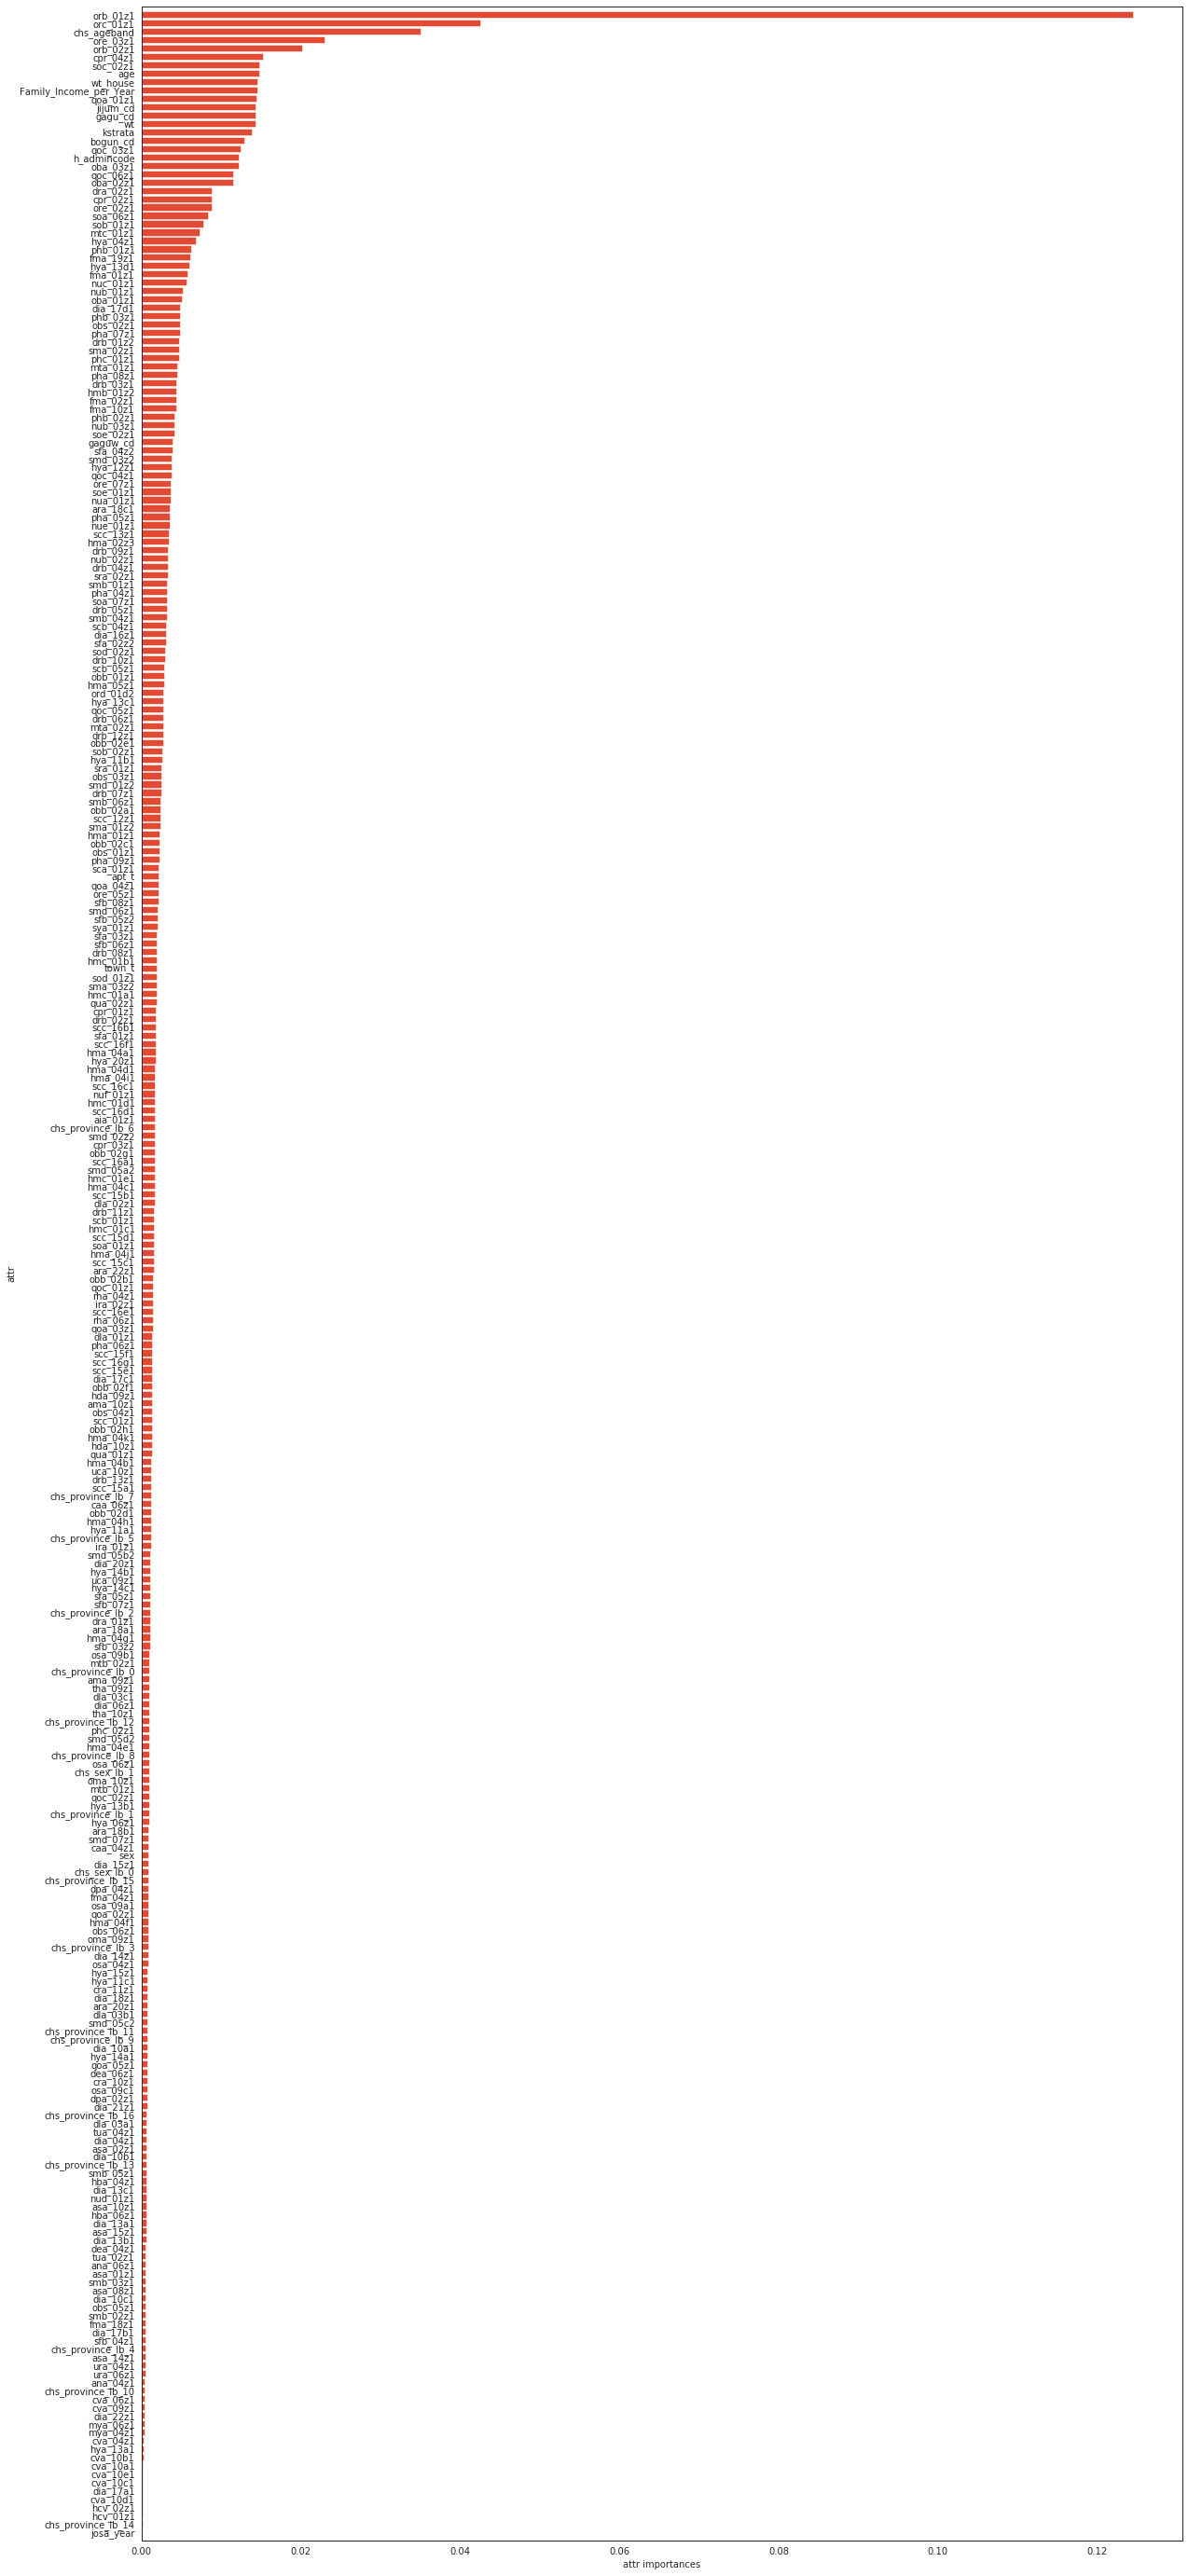

In [129]:
plot_feature_importances_rf(rf_model_tot, train_x)

In [135]:
rf_importances_sorted = display_random_forest_feature_importances(rf_model_tot, train_x)

,Gini-importance
orb_01z1,0.124440
orc_01z1,0.042556
chs_ageband,0.035007
ore_03z1,0.023007
orb_02z1,0.020126
...,...
cva_10d1,0.000168
hcv_02z1,0.000156
hcv_01z1,0.000125
chs_province_lb_14,0.000097


In [136]:
# Random Forest 기준 30개 변수 선택
rf_selected_cols = rf_importances_sorted[:30].index.tolist()
print(rf_selected_cols)
train_x_rf1 = train_x[rf_selected_cols]
test_x_rf1 = test_x[rf_selected_cols]

['orb_01z1', 'orc_01z1', 'chs_ageband', 'ore_03z1', 'orb_02z1', 'cpr_04z1', 'soc_02z1', 'age', 'wt_house', 'Family_Income_per_Year', 'qoa_01z1', 'jijum_cd', 'gagu_cd', 'wt', 'kstrata', 'bogun_cd', 'qoc_03z1', 'h_admincode', 'oba_03z1', 'qoc_06z1', 'oba_02z1', 'dra_02z1', 'cpr_02z1', 'ore_02z1', 'soa_06z1', 'sob_01z1', 'mtc_01z1', 'hya_04z1', 'phb_01z1', 'fma_19z1']


In [125]:
# Random Forest 기준 30개 변수 기준 모델 Run
rf_model_rf1 = rf_run(train_x_rf1, train_y, test_x_rf1, test_y)

Accuracy: 0.76973
Confusion Matrix: 
 [[33751  7028]
 [ 8785 19107]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0       0.79      0.83      0.81     40779
         1.0       0.73      0.69      0.71     27892

    accuracy                           0.77     68671
   macro avg       0.76      0.76      0.76     68671
weighted avg       0.77      0.77      0.77     68671



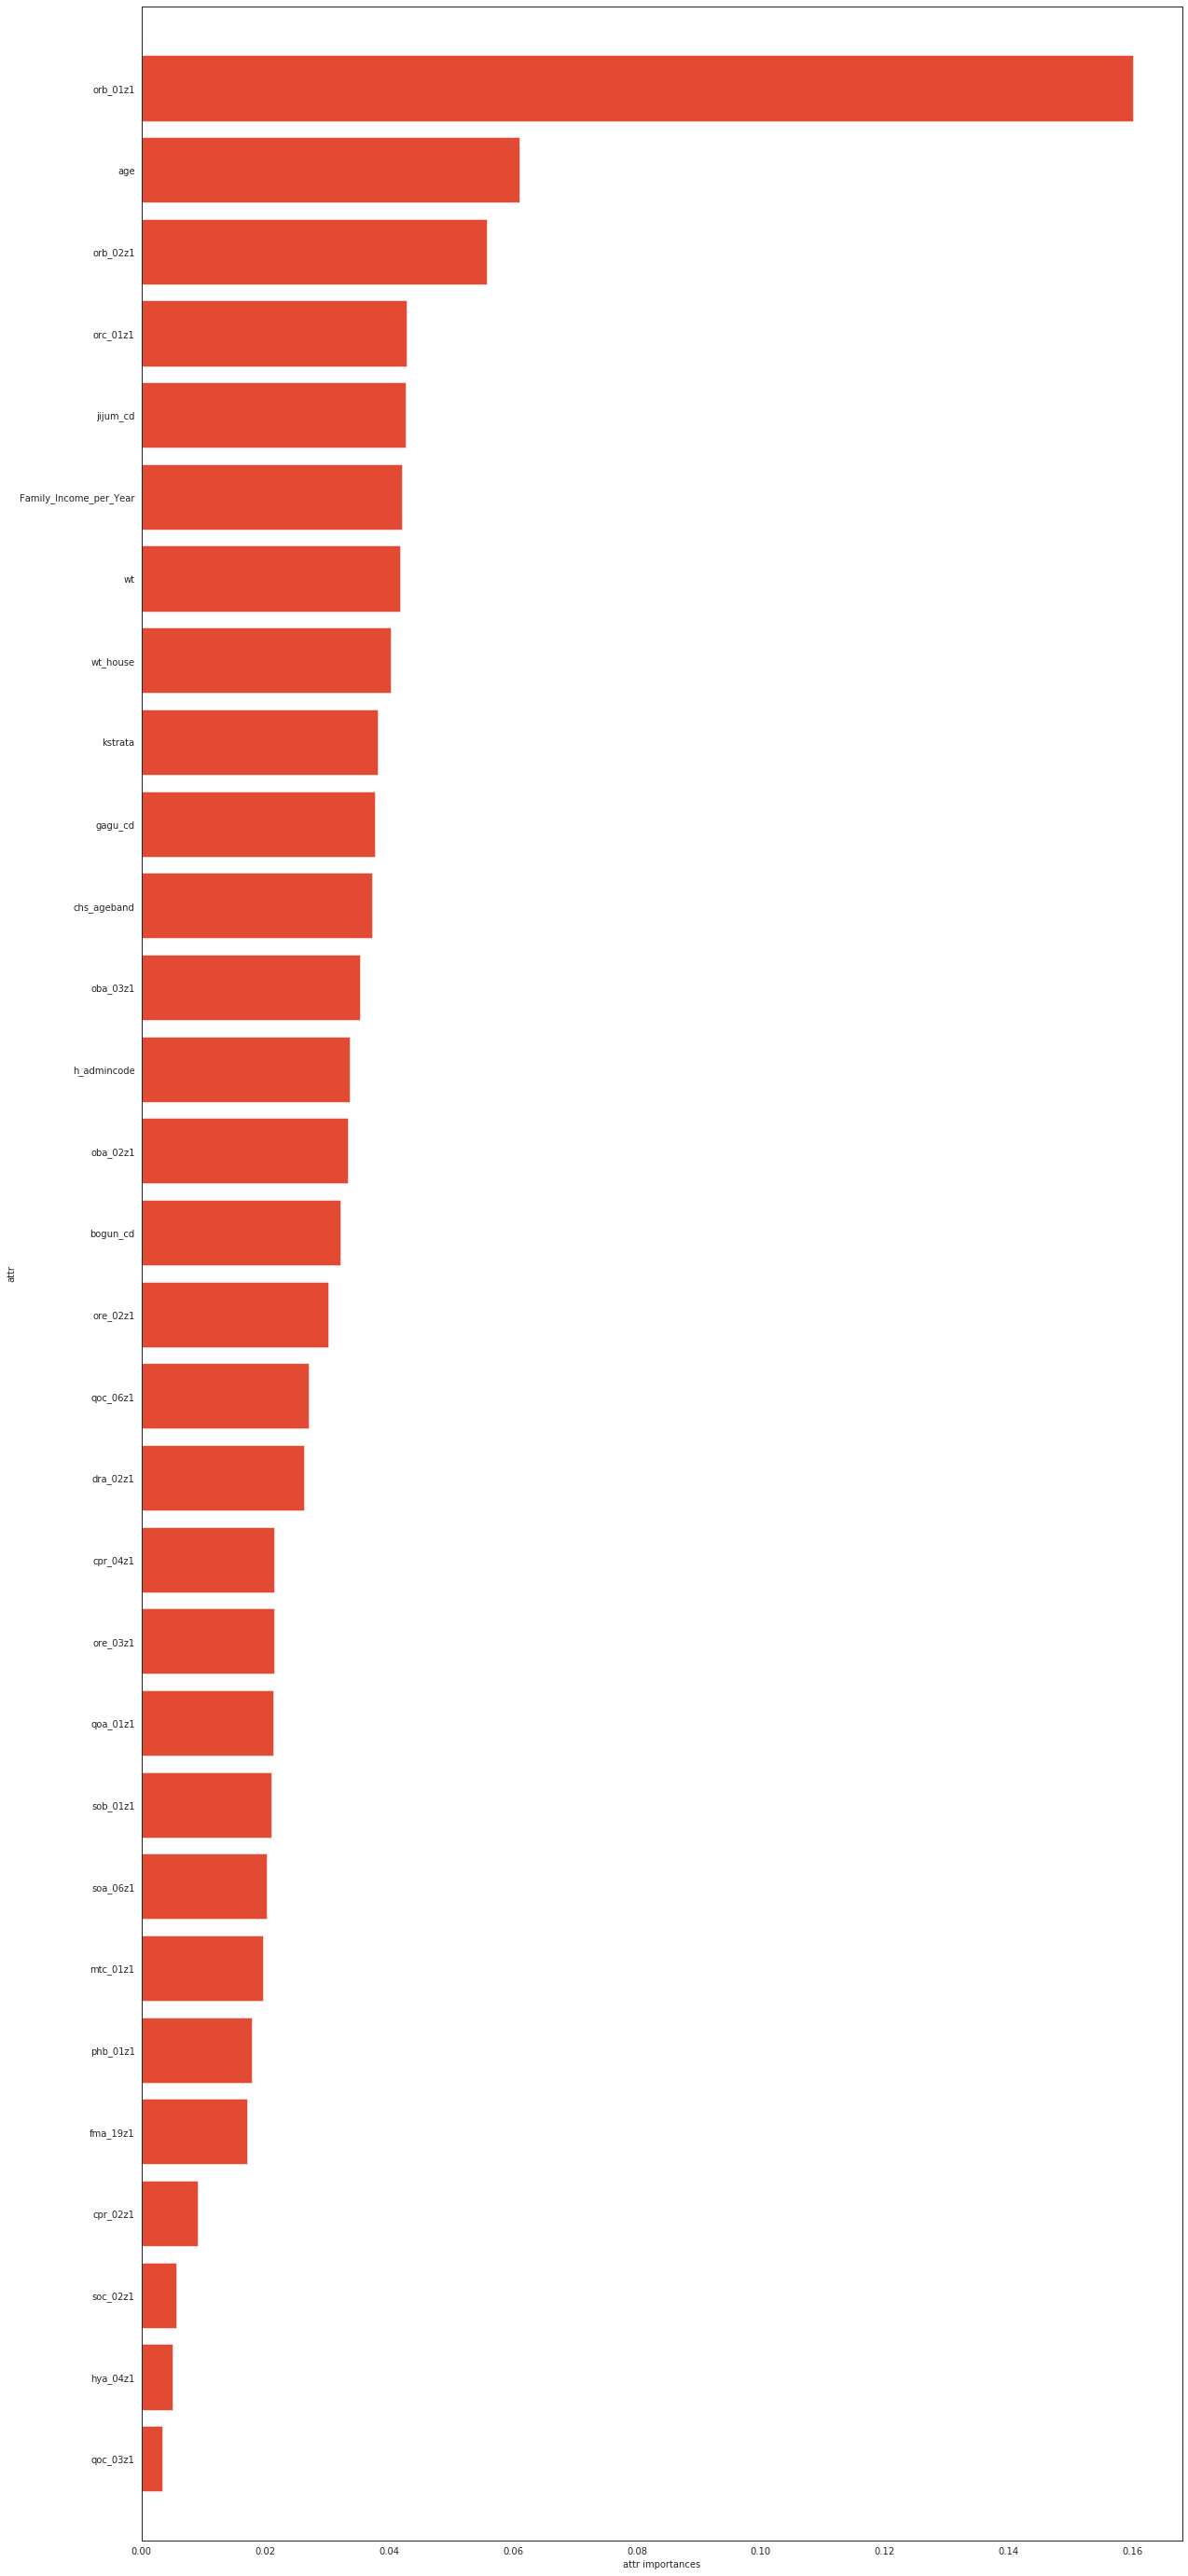

In [130]:
plot_feature_importances_rf(rf_model_rf1, train_x_rf1)

In [137]:
rf_importances_sorted_1 = display_random_forest_feature_importances(rf_model_rf1, train_x_rf1)

,Gini-importance
orb_01z1,0.160019
age,0.061040
orb_02z1,0.055714
orc_01z1,0.042821
jijum_cd,0.042679
Family_Income_per_Year,0.042048
wt,0.041806
wt_house,0.040296
kstrata,0.038125
gagu_cd,0.037696


In [138]:
# IV 산출
second_iv_df, IV_second = calc_iv_all(data_x[rf_selected_cols],data_y)
# first_iv_df

# IV 값 내림차순 정렬
IV_second_sorted = IV_second.sort_values('IV',ascending=False)
IV_second_sorted

,VAR_NAME,IV
1,age,0.535178
28,wt,0.110631
0,Family_Income_per_Year,0.057812
22,qoa_01z1,0.057812
29,wt_house,0.057812
9,h_admincode,0.040231
12,kstrata,0.039046
2,bogun_cd,0.038396
23,qoc_03z1,0.038396
11,jijum_cd,0.029659


In [0]:
IV_second.to_csv('../gdrive/My Drive/sds/data/chs_12_iv_second.csv')

In [0]:
# Random Forest 및 IV 값 데이터 기준 수작업으로 column 선택
test_cols = ['chs_sex','chs_ageband','chs_province','oba_03z1','oba_02z1','Family_Income_per_Year','ama_09z1','ana_04z1','ara_20z1','asa_08z1','orb_01z1','hba_04z1','hcv_01z1','hda_09z1','hma_01z1','hya_04z1','orb_02z1','orc_01z1','qoa_01z1','qoc_06z1','sob_01z1','ore_02z1','qoc_03z1','cpr_01z1','dra_02z1','fma_01z1','mtc_01z1','aia_01z1','hya_13d1','phb_01z1','phb_03z1','sma_02z1','nuc_01z1','drb_01z2','phc_01z1','qoc_04z1','qoc_01z1','dia_17d1','mta_01z1','pha_08z1','drb_03z1','nua_01z1','qoc_02z1','pha_04z1','target']
df_test_corr = df_final[test_cols].copy()

In [140]:
# 컬럼 특성상 이상 데이터로 간주 가능한 데이터만 선택
# 키 2m 이하, 몸무게 200kg 이하, 혈압측정회수 100회 이하, 음주시작연령 100세 미만 데이터만 가져옴
df_selected_var = df_test_corr[(df_test_corr['oba_02z1']<=200) & (df_test_corr['oba_03z1']<=200) & (df_test_corr['hya_13d1']<=100) & (df_test_corr['dra_02z1']<=100)].copy()
df_selected_var.describe()

,chs_ageband,oba_03z1,oba_02z1,Family_Income_per_Year,ama_09z1,ana_04z1,ara_20z1,asa_08z1,orb_01z1,hba_04z1,hcv_01z1,hda_09z1,hma_01z1,hya_04z1,orb_02z1,orc_01z1,qoa_01z1,qoc_06z1,sob_01z1,ore_02z1,qoc_03z1,cpr_01z1,dra_02z1,fma_01z1,mtc_01z1,aia_01z1,hya_13d1,phb_01z1,phb_03z1,sma_02z1,nuc_01z1,drb_01z2,phc_01z1,qoc_04z1,qoc_01z1,dia_17d1,mta_01z1,pha_08z1,drb_03z1,nua_01z1,qoc_02z1,pha_04z1,target
count,228806.000000,228806.000000,228806.000000,2.288060e+05,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000,228806.000000
mean,49.413368,60.393831,155.613806,6.454717e+04,1.938926,1.979874,1.865869,1.971705,3.790692,1.975071,1.995538,1.918398,1.559963,1.767961,4.437025,3.574316,2.811386,72.293576,4.766610,1.768953,1.136408,1.297588,17.736528,3.023850,6.674143,1.224509,1.982968,3.874562,12.693404,7.693832,2.947401,1.852163,2.039461,1.295324,1.166674,1.015782,2.899723,0.736440,1.589954,5.793489,1.059697,0.746095,0.405225
std,16.830723,14.627558,36.870947,2.480971e+05,0.241429,0.146912,0.342036,0.167518,1.320058,0.161798,0.082424,0.274316,0.857691,0.422621,0.971664,0.991425,0.931157,18.156079,1.808229,0.421991,0.370072,0.467306,12.372339,1.336215,1.272584,0.427258,3.634708,2.833117,14.917080,10.666382,1.076010,1.710210,0.839354,0.509435,0.387338,4.111820,0.752363,1.771643,1.616987,2.320114,0.260322,1.719954,0.490937
min,20.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,53.000000,157.000000,1.500000e+03,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,4.000000,4.000000,2.000000,60.000000,3.000000,2.000000,1.000000,1.000000,15.000000,2.000000,6.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,6.000000,1.000000,0.000000,0.000000
50%,50.000000,60.000000,163.000000,3.000000e+03,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,2.000000,5.000000,4.000000,3.000000,80.000000,5.000000,2.000000,1.000000,1.000000,19.000000,3.000000,7.000000,1.000000,1.000000,4.000000,0.000000,0.000000,3.000000,2.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,7.000000,1.000000,0.000000,0.000000
75%,65.000000,69.000000,170.000000,5.200000e+03,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,4.000000,3.000000,85.000000,6.000000,2.000000,1.000000,2.000000,21.000000,4.000000,7.000000,1.000000,3.000000,7.000000,30.000000,19.000000,3.000000,3.000000,2.000000,2.000000,1.000000,1.000000,3.000000,0.000000,3.000000,7.000000,1.000000,0.000000,1.000000
max,85.000000,180.000000,197.000000,1.199988e+06,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,2.000000,2.000000,4.000000,2.000000,5.000000,4.000000,5.000000,100.000000,8.000000,2.000000,3.000000,2.000000,91.000000,12.000000,20.000000,2.000000,100.000000,7.000000,59.000000,84.000000,5.000000,5.000000,4.000000,3.000000,3.000000,730.000000,4.000000,18.000000,5.000000,7.000000,3.000000,7.000000,1.000000


In [141]:
# 상관계수 검증을 위한 연속형 변수 탐색
num_features_for_corr = [col for col in df_selected_var.columns if df_selected_var[col].dtypes != "object"]
num_features_for_corr = np.sort(num_features_for_corr)

from pprint import pprint as pp

corr_dict = {}

for i in num_features_for_corr:
    corr_dict[i] = df_selected_var['target'].astype('float64').corr(df_selected_var[i])

pp(corr_dict)

{'Family_Income_per_Year': -0.001816746276669141,
 'aia_01z1': 0.20090233438165858,
 'ama_09z1': -0.02671078159407617,
 'ana_04z1': -0.062229461316841365,
 'ara_20z1': -0.18986335873326202,
 'asa_08z1': -0.06236713916913676,
 'chs_ageband': 0.3404369487594452,
 'cpr_01z1': 0.22885833555083168,
 'dia_17d1': 0.02711927253304032,
 'dra_02z1': 0.001774112208880617,
 'drb_01z2': -0.07362528878237572,
 'drb_03z1': -0.10460231092178414,
 'fma_01z1': -0.15124587358852548,
 'hba_04z1': -0.01852005956337537,
 'hcv_01z1': -0.023574260651981305,
 'hda_09z1': -0.024827909595821828,
 'hma_01z1': 0.15285227137826987,
 'hya_04z1': -0.16895613037038415,
 'hya_13d1': 0.015460291566114441,
 'mta_01z1': -0.03788227107830701,
 'mtc_01z1': -0.051362852071068464,
 'nua_01z1': 0.0792520033120876,
 'nuc_01z1': 0.19405550388825837,
 'oba_02z1': -0.16408225306551755,
 'oba_03z1': -0.09867802729382409,
 'orb_01z1': -0.5983547499927304,
 'orb_02z1': -0.4040474028330655,
 'orc_01z1': -0.36077990277684213,
 'ore_02z

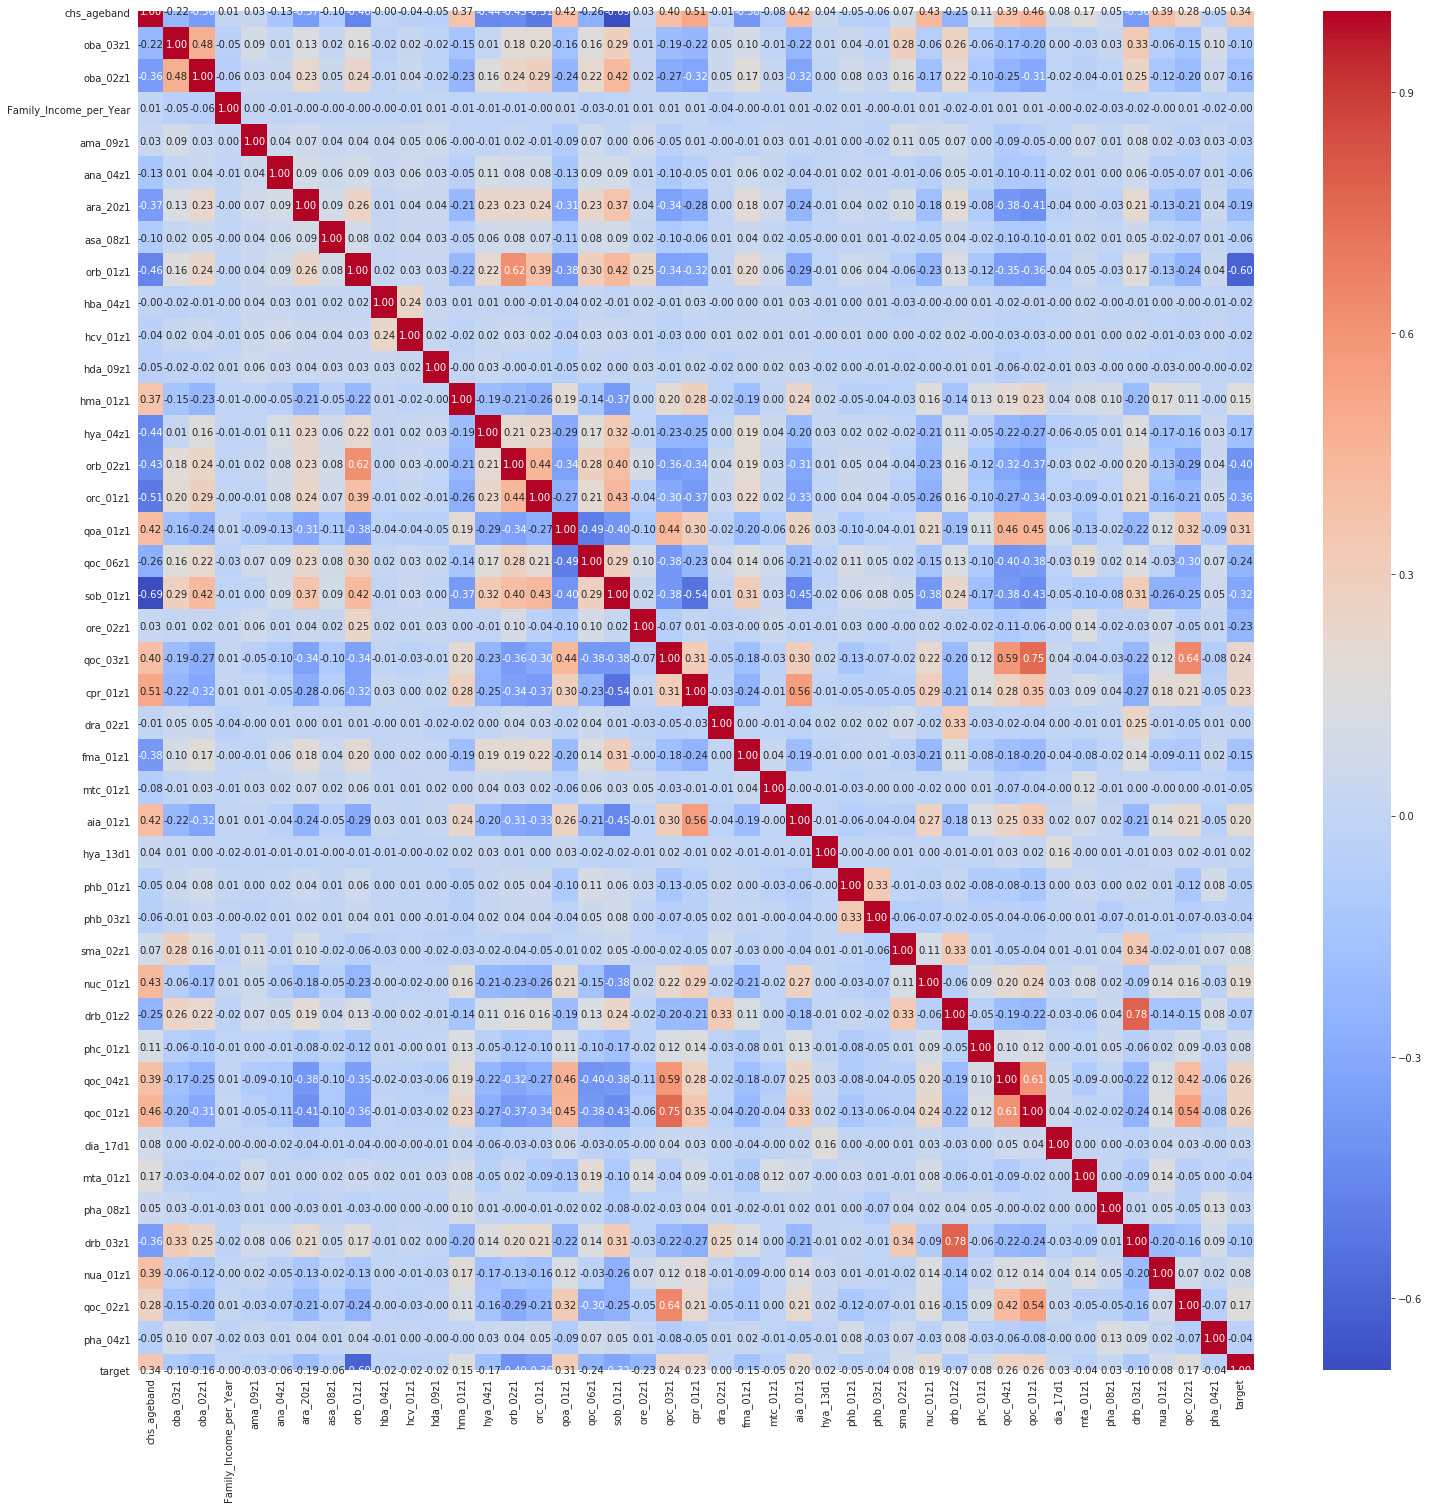

In [142]:
# 데이터 간의 상관관계 체크
# 수치형변수들과 변수의 상관관계 Matrix 시각화
df_corr = df_selected_var.corr()

plt.figure(figsize=(25, 25))
sns.heatmap(df_corr,annot=True, fmt = ".2f", cmap = "coolwarm")
# plt.matshow(df_corr.corr())
# plt.show()

In [143]:
df_corr['target'].sort_values(ascending=False)

target                    1.000000
chs_ageband               0.340437
qoa_01z1                  0.314706
qoc_01z1                  0.262343
qoc_04z1                  0.259490
qoc_03z1                  0.236843
cpr_01z1                  0.228858
aia_01z1                  0.200902
nuc_01z1                  0.194056
qoc_02z1                  0.165073
hma_01z1                  0.152852
sma_02z1                  0.084272
phc_01z1                  0.082021
nua_01z1                  0.079252
dia_17d1                  0.027119
pha_08z1                  0.026581
hya_13d1                  0.015460
dra_02z1                  0.001774
Family_Income_per_Year   -0.001817
hba_04z1                 -0.018520
hcv_01z1                 -0.023574
hda_09z1                 -0.024828
ama_09z1                 -0.026711
mta_01z1                 -0.037882
pha_04z1                 -0.040608
phb_03z1                 -0.041938
mtc_01z1                 -0.051363
phb_01z1                 -0.051403
ana_04z1            

In [144]:
# df_selected_var.to_csv('../gdrive/My Drive/sds/data/chs_12_var_selected_original.csv')
# df_selected_var.to_csv('../gdrive/My Drive/sds/data/chs_12_var_selected.csv')
# df_selected_var = pd.read_csv('../gdrive/My Drive/sds/data/chs_12_var_selected_original.csv', encoding = 'EUC-KR')
df_selected_var.columns

Index(['chs_sex', 'chs_ageband', 'chs_province', 'oba_03z1', 'oba_02z1',
       'Family_Income_per_Year', 'ama_09z1', 'ana_04z1', 'ara_20z1',
       'asa_08z1', 'orb_01z1', 'hba_04z1', 'hcv_01z1', 'hda_09z1', 'hma_01z1',
       'hya_04z1', 'orb_02z1', 'orc_01z1', 'qoa_01z1', 'qoc_06z1', 'sob_01z1',
       'ore_02z1', 'qoc_03z1', 'cpr_01z1', 'dra_02z1', 'fma_01z1', 'mtc_01z1',
       'aia_01z1', 'hya_13d1', 'phb_01z1', 'phb_03z1', 'sma_02z1', 'nuc_01z1',
       'drb_01z2', 'phc_01z1', 'qoc_04z1', 'qoc_01z1', 'dia_17d1', 'mta_01z1',
       'pha_08z1', 'drb_03z1', 'nua_01z1', 'qoc_02z1', 'pha_04z1', 'target'],
      dtype='object')

In [0]:
df_final = df_selected_var.rename(columns={'chs_sex':'chs_sex',
                                        'chs_ageband':'chs_ageband',
                                        'chs_province':'chs_province',
                                        'oba_03z1':'chs_weight',
                                        'oba_02z1':'chs_height',
                                        'Family_Income_per_Year':'chs_income',
                                        'ama_09z1':'Anemia_Diagnosis',
                                        'ana_04z1':'Angina_Pectoris_Diagnosis',
                                        'ara_20z1':'Arthritis_Diagnosis',
                                        'asa_08z1':'Asthma_Diagnosis',
                                        'orb_01z1':'Mastication_Disturb',
                                        'hba_04z1':'Btype_HepatitisDiagnosis',
                                        'hcv_01z1':'Ctype_HepatitisDiagnosis',
                                        'hda_09z1':'Hemorrhoids_Diagnosis',
                                        'hma_01z1':'Health_Institution_Experience',
                                        'hya_04z1':'HBP_Diagnosis',
                                        'orb_02z1':'Pronounce_Disturb',
                                        'orc_01z1':'Denture_Use',
                                        'qoa_01z1':'Subjective_Health_Level',
                                        'qoc_06z1':'EQ_VAS',
                                        'sob_01z1':'Final_Edu_Grade',
                                        'ore_02z1':'Dent_DidNot_Exp',
                                        'qoc_03z1':'EQ_5D_Normal_Life',
                                        'cpr_01z1':'CPR_Recognition',
                                        'dra_02z1':'Drink_Start_Age',
                                        'fma_01z1':'Family_Cnt',
                                        'mtc_01z1':'Ave_SleepTime',
                                        'aia_01z1':'AIDS_Recognition',
                                        'hya_13d1':'BP_Check_CNT_Per_Year',
                                        'phb_01z1':'Walking_Day',
                                        'phb_03z1':'Walking_Minutes',
                                        'sma_02z1':'Smoking_Start_Age',
                                        'nuc_01z1':'Nutri_Check',
                                        'drb_01z2':'Drink_Freq',
                                        'phc_01z1':'Near_GYM',
                                        'qoc_04z1':'EQ_5D_Pain',
                                        'qoc_01z1':'EQ_5D_Athletic_Ability',
                                        'dia_17d1':'BP_Check_CNT_Per_Year',
                                        'mta_01z1':'Stress_Index',
                                        'pha_08z1':'Exercise_Mid_Hour',
                                        'drb_03z1':'Drink_Per_Once',
                                        'nua_01z1':'Breakfast_per_Week',
                                        'qoc_02z1':'EQ_5D_Self_Manage',
                                        'pha_04z1':'Exercise_High_Hour'})

In [154]:
df_final['chs_weight'] = df_final['chs_weight'].apply(lambda x: math.floor(x/5)*5)
df_final['chs_height'] = df_final['chs_height'].apply(lambda x: math.floor(x/5)*5)
df_final

,chs_sex,chs_ageband,chs_province,chs_weight,chs_height,chs_income,Anemia_Diagnosis,Angina_Pectoris_Diagnosis,Arthritis_Diagnosis,Asthma_Diagnosis,Mastication_Disturb,Btype_HepatitisDiagnosis,Ctype_HepatitisDiagnosis,Hemorrhoids_Diagnosis,Health_Institution_Experience,HBP_Diagnosis,Pronounce_Disturb,Denture_Use,Subjective_Health_Level,EQ_VAS,Final_Edu_Grade,Dent_DidNot_Exp,EQ_5D_Normal_Life,CPR_Recognition,Drink_Start_Age,Family_Cnt,Ave_SleepTime,AIDS_Recognition,BP_Check_CNT_Per_Year,Walking_Day,Walking_Minutes,Smoking_Start_Age,Nutri_Check,Drink_Freq,Near_GYM,EQ_5D_Pain,EQ_5D_Athletic_Ability,BP_Check_CNT_Per_Year,Stress_Index,Exercise_Mid_Hour,Drink_Per_Once,Breakfast_per_Week,EQ_5D_Self_Manage,Exercise_High_Hour,target
0,Female,45,Gyeonggi,60,155,3000,2,2,1,2,5,2,2,2,1,2,5,4,1,80,5,2,1,2,20,3,6,2,0,5,0,0,2,3,2,1,1,3,3,0,1,7,1,0,0
1,Female,70,Gangwon,60,150,4800,2,2,2,1,2,2,2,2,2,2,5,4,3,90,4,1,1,2,0,4,6,1,2,7,30,0,5,0,2,1,1,0,3,0,0,7,1,0,0
2,Male,45,Gyeonggi,75,165,4800,2,2,2,2,4,2,2,2,1,2,5,4,2,98,4,2,1,2,15,5,7,1,10,6,0,18,3,4,0,1,1,0,4,8,2,7,1,2,0
3,Female,25,Gyeonggi,50,165,933324,2,2,2,2,5,2,2,2,2,2,5,4,2,70,7,2,1,1,19,1,7,1,0,2,0,0,3,2,1,1,1,0,3,0,1,7,1,0,0
4,Male,35,Gyeonggi,80,170,6000,2,2,2,2,5,2,2,2,1,2,5,4,3,70,7,2,1,1,16,6,6,1,3,7,30,19,2,2,1,1,1,1,2,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228896,Male,80,Jeonnam,65,165,600,2,2,2,1,4,2,2,2,4,1,5,1,4,80,4,2,1,2,23,2,7,1,0,0,0,18,3,3,3,1,1,2,4,0,1,7,1,0,1
228897,Male,45,Seoul,70,170,3600,2,2,2,1,2,2,2,2,1,2,5,4,3,85,6,2,1,1,17,7,5,1,0,6,0,22,3,3,2,1,1,2,2,0,5,7,1,7,1
228898,Female,45,Jeonnam,60,155,1200,2,2,1,2,5,2,2,1,1,1,5,4,4,50,4,2,1,1,20,2,6,1,0,6,0,0,2,2,0,2,1,1,2,0,1,5,1,6,1
228899,Female,70,Gangwon,55,140,840,2,2,1,2,2,2,2,1,3,1,4,1,5,30,1,2,2,2,0,2,9,2,0,2,20,0,4,0,3,3,2,1,4,0,0,7,2,0,1


In [0]:
df_final.to_csv('../gdrive/My Drive/sds/data/chs_12_final_from_python.csv')

In [0]:
# group by로 키를 묶고, 키 별 평균값을 구하자